# Examples for NALOME 2023 paper "TTR goes to the SPA"
@InProceedings{Larsson:Cooper:Ginzburg:Luecking:2023-ttr-spa,
  author =	 {Larsson, Staffan and Cooper, Robin and Ginzburg, Jonathan and Lücking, Andy},
  title =	 {{TTR} at the {SPA}: {Relating} type-theoretical semantics to neural semantic pointers},
  booktitle =	 {Proceedings of Natural Logic Meets Machine Learning IV},
  series =	 {NALOMA'23},
  location =	 {Nancy, France, hosted with IWCS 2023}
}


In [1]:
import nengo
import nengo_spa as spa
import numpy as np
import matplotlib.pyplot as plt

These libraries are used for all examples. 
Apart from that, each example can be run on its own.
For obtaining and using the Nengo libraries see https://www.nengo.ai/.

## F structure
### unbind basic type

In [2]:
d = 128
# works much better than d = 64
with spa.Network("F") as f:
    f_state = spa.State(vocab=d)
    query = spa.State(vocab=d)
    
    spa.sym("(IND * (A + B + C)) + (INT * (ONE + TWO + THREE))") >> f_state
    f_state * spa.sym("~IND") >> query
    
    p = nengo.Probe(query.output, synapse=0.01)

In [3]:
with nengo.Simulator(f) as sim:
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

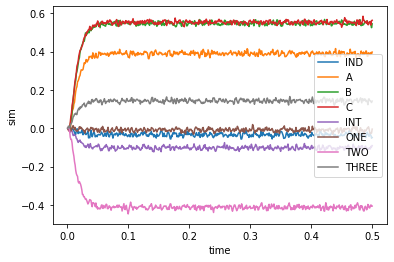

In [4]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p], query.vocab))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(query.vocab, loc="best")

## Binding distributes over bundling

In [58]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("A; B; C")

# ensure same number of digits (namely 10)
pointer_bundle = np.round(vocab.parse("A * B + A * C").v, 10)
pointer_distrib = np.round(vocab.parse("A * (B + C)").v, 10)

In [59]:
if np.array_equal(pointer_bundle, pointer_distrib):
    print("equal")
else:
    print("different")

equal


# Singleton types

In [41]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("A; T; B; B_EQ_A = A")

def rehearsal(t):
    if t < 0.25:
        return "T + A"
    elif t < 0.5:
        return "T + B"
    else:
        return "T + B_EQ_A"
    
with spa.Network("Singletons") as model:
    out = spa.State(vocab=vocab)
    query = spa.Transcode(rehearsal, output_vocab=vocab)
    
    query >> out
    
    p = nengo.Probe(out.output, synapse=0.01)

In [42]:
with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

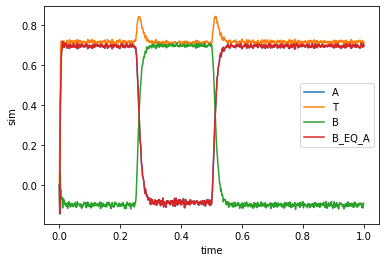

In [47]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p], out.vocab, normalize=True))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(out.vocab, loc="best")

# Paths
Bind type t2 to t1 by a path of three labels: t1 * l1 * l2 * l3 : t2.
Run several times, goodness of results vary. 

In [23]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("T2; L1; L2; L3; L4; T1 = L1 * L2 * L3 * L4 * T2")

with spa.Network("Paths") as model:
    out = spa.State(vocab=d)
    query = spa.Transcode(lambda t: 
                          "T1 * ~L1 * ~L2 * ~L3 * ~L4" if t < 0.25 
                          else "T2", output_vocab=d)
    
    query >> out
    
    p = nengo.Probe(out.output, synapse=0.01)

In [24]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

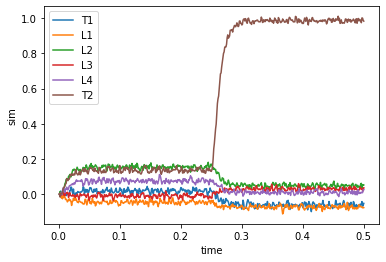

In [25]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p], out.vocab))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(out.vocab, loc="best")

## Variant
Version in paper makes use of additional "path type" T3, as shown below.
Rerun several times since results vary 

In [39]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("T1; T2; L1; L2; L3; L4; T3 = (T1 * L1 * L2 * L3 * L4 * T2)")

with spa.Network("Paths") as model:
    out = spa.State(vocab=d)
    query = spa.Transcode(lambda t: 
                          "T3 * ~T1 * ~L1 * ~L2 * ~L3 * ~L4" if t < 0.25 
                          else "T2", output_vocab=d)
    
    query >> out
    
    p = nengo.Probe(out.output, synapse=0.01)

In [40]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

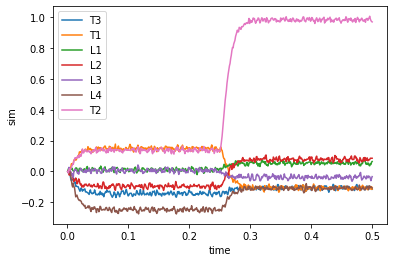

In [41]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p], out.vocab))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(out.vocab, loc="best")

## Subtypes

In [48]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("L1; L2; T1; T2")

supertype = np.round(vocab.parse("L1 * T1").v, 10)
subtype = np.round(vocab.parse("L1 * T1 + L2 * T2").v, 10)

sim_base = spa.similarity(subtype,subtype,normalize=True)
sim_norm = spa.similarity(supertype,subtype,normalize=True)

print("Identity:", sim_base)
print("Sim:", sim_norm)

sim_max = spa.similarity(np.maximum(supertype,subtype),subtype,normalize=True)
print("Sim max:", sim_max)

Identity: [1.]
Sim: [0.65160681]
Sim max: [0.8314121]


# Functions

In [50]:
d = 64

def inputs(t):
    if t < 0.25:
        return "A"
    else:
        return "B"
    
with spa.Network("Functions") as func:
    xind = spa.State(vocab=d)
    xrun = spa.State(vocab=d)
    runner = spa.State(vocab=d)
    input = spa.Transcode(inputs, output_vocab=d)
    
    input * spa.sym("IND") >> xind 
    xind * spa.sym("ARG0") + spa.sym("PRED * RUN") >> xrun
    
    # who runs?
    xrun * spa.sym("~ARG0") >> runner

    p = nengo.Probe(runner.output, synapse=0.01)

In [51]:
with nengo.Simulator(func) as sim:
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

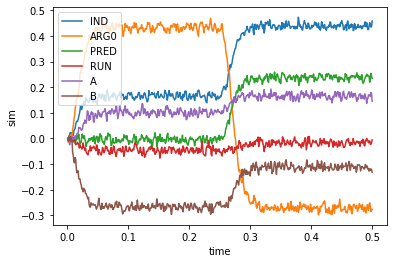

In [52]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p], runner.vocab))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(runner.vocab, loc="best")